### Imports
***

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
# Read list of names
words = open("assets/names.txt", "r").read().splitlines()

In [3]:
# List of all characters in document
chars = sorted(list(set("".join(words))))

# Mapping tables between characters and integers
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

# Number of unique characters
vocab = len(chars)+1

### Count-Based Model
***

In [4]:
# Empty matrix where we will collect number occurences from letter A to B
N = torch.zeros((vocab, vocab), dtype=torch.int32)

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        N[ix1, ix2] += 1

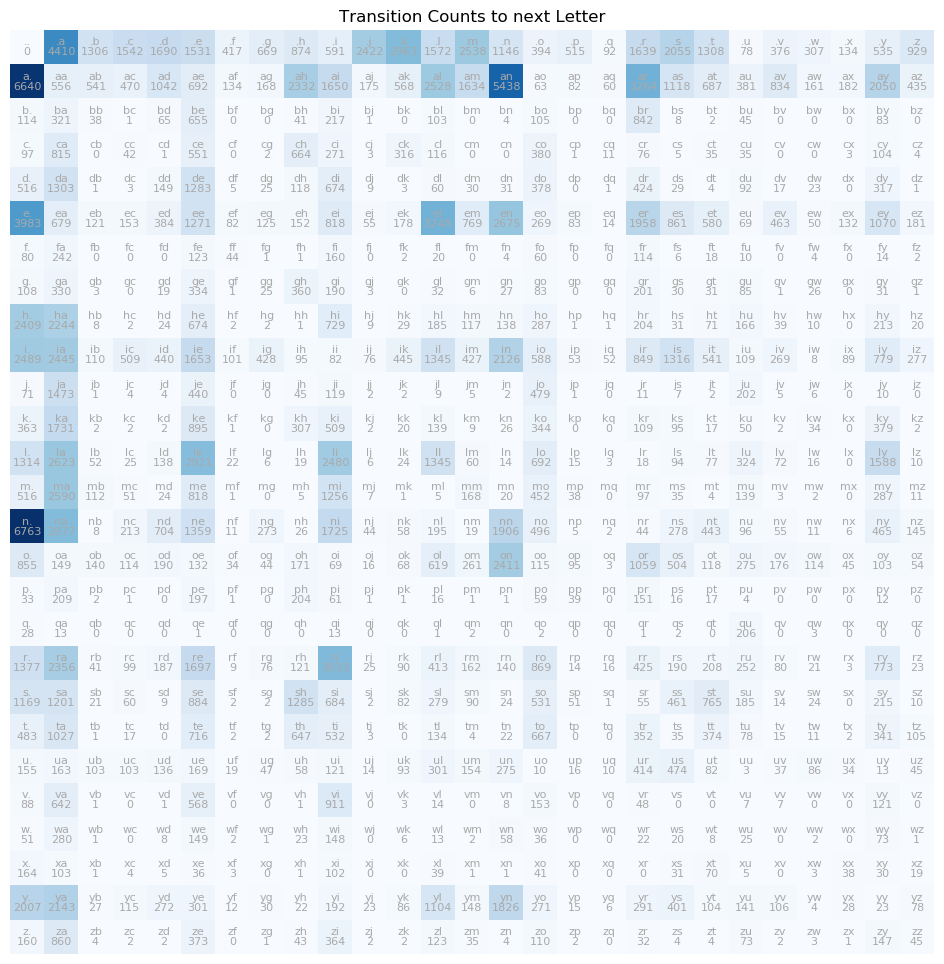

In [5]:
%matplotlib inline

plt.figure(figsize=(12,12))
plt.imshow(N, cmap="Blues")

for i in range(vocab):
    for j in range(vocab):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="darkgray", fontsize=8)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="darkgray", fontsize=8)

plt.title("Transition Counts to next Letter")
plt.axis("off")
plt.show()

In [6]:
# To obtain probabilities, we need to normalize to 1
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

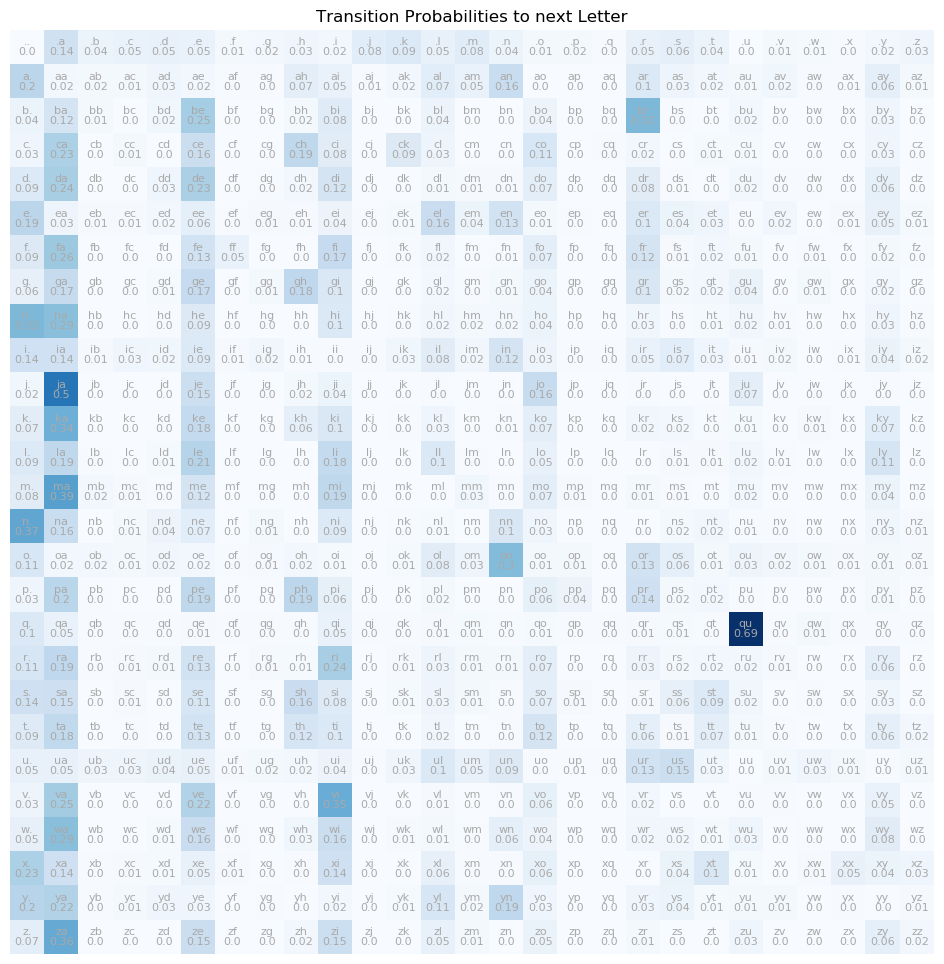

In [7]:
%matplotlib inline

plt.figure(figsize=(12,12))
plt.imshow(P, cmap="Blues")

for i in range(vocab):
    for j in range(vocab):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="darkgray", fontsize=8)
        plt.text(j, i, round(P[i, j].item(),2), ha="center", va="top", color="darkgray", fontsize=8)

plt.title("Transition Probabilities to next Letter")
plt.axis("off")
plt.show()

In [8]:
# Calculate the log-likelihood of the model on seeing the data
log_likelihood = 0.0
n = 0

for w in words:
  chs = ["."] + list(w) + ["."]
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]

    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

# Since we want to minimize, we take the negative log-likelihood
nll = -log_likelihood/n
print("Average negative log likelihood:", nll.item())

Average negative log likelihood: 2.4543561935424805


In [9]:
# Random number generator with fixed seed
g = torch.Generator().manual_seed(0)
# Sample a new name from the probability matrix
out = []
# We start at the start/end token, which has index 0
ix = 0

while True:
    p = P[ix]
    # Sample from ix row in matrix of probabilities for new character
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    # Append sampled character
    out.append(itos[ix])
    # Stop iteration when start/end token is reached
    if ix == 0:
        break

print("". join(out))

bhrirerirco.


### 1-Layer Neural Network
***

In [10]:
# Create the training set of bigrams (x,y)
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)
obs = xs.nelement()

print("X: {}, {}".format(xs.shape, xs))
print("Y: {}, {}".format(ys.shape, ys))

X: torch.Size([228146]), tensor([ 0,  5, 13,  ..., 25, 26, 24])
Y: torch.Size([228146]), tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [11]:
# As the encoded characters have no ordinal meaning, they need to be OHE.
# For the neural network, we need to cast from integer to float.
xenc = F.one_hot(xs, num_classes=27).float()
print("X one-hot-encoded:", xenc.shape)

X one-hot-encoded: torch.Size([228146, 27])


In [12]:
# Randomly initialize weights for each of the neurons.
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator=g, requires_grad=True)

print("W: {}, {} input weights for {} neurons".format(
    W.shape, 
    W.shape[0], 
    W.shape[1]
))
# The 1st column represents the weights going into the 1st neuron.
# The 1st row represents the weights of the input on first position weights going into all neurons.
W[0]

W: torch.Size([27, 27]), 27 input weights for 27 neurons


tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
        -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
         1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
         1.2791,  1.2964,  0.6105], grad_fn=<SelectBackward0>)

In [13]:
# Raw firing rate of each neuron for each observation.
logits = xenc @ W

print("Logits: {}, firing rate of {} observations for {} neurons".format(
    logits.shape, 
    logits.shape[0], 
    logits.shape[1])
)
# Raw firing rate of each neuron in the 1st observation.
logits[0]

Logits: torch.Size([228146, 27]), firing rate of 228146 observations for 27 neurons


tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
        -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
         1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
         1.2791,  1.2964,  0.6105], grad_fn=<SelectBackward0>)

In [14]:
# Softmax converts logits into probabilities
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

# Firing rate of 5 observations with their 27 neurons.
print("Probs: {}, firing rate of {} observations for {} neurons".format(
    probs.shape, 
    probs.shape[0], 
    probs.shape[1])
)
# Raw firing rate of the 27 neurons in the 1st observation.
probs[0]

Probs: torch.Size([228146, 27]), firing rate of 228146 observations for 27 neurons


tensor([0.1230, 0.0793, 0.0441, 0.0022, 0.0353, 0.0052, 0.0172, 0.0036, 0.0084,
        0.0932, 0.0121, 0.0044, 0.0087, 0.0102, 0.0083, 0.0384, 0.0926, 0.0153,
        0.0109, 0.0278, 0.0084, 0.0527, 0.0399, 0.0962, 0.0644, 0.0655, 0.0330],
       grad_fn=<SelectBackward0>)

In [15]:
# Average negative log likelihood
loss = -probs[torch.arange(obs), ys].log().mean()
print(loss)

tensor(3.6966, grad_fn=<NegBackward0>)


In [16]:
# We need to ensure that the gradient attribute is set to 0, as the values are accumulated with each iteration.
W.grad = None

# This operation does the backprop through the whole computational graph
# The gradients are stored under the .grad attribute for all leaf-tensors, where 'require_grad=True'.
loss.backward()

In [17]:
# Update the parameters with the learning rate times the negative gradient.
lr = 0.1
W.data += lr * -W.grad

# The '.data' attribute is the same as the object itself, just without gradient information.
print(W[0])
print(W[0].data)

tensor([ 1.9252,  1.4881,  0.9007, -2.1049,  0.6787, -1.2339, -0.0431, -1.6044,
        -0.7519,  1.6477, -0.3916, -1.4024, -0.7273, -0.5585, -0.7685,  0.7621,
         1.6412, -0.1598, -0.4968,  0.4401, -0.7577,  1.0776,  0.8004,  1.6794,
         1.2783,  1.2957,  0.6104], grad_fn=<SelectBackward0>)
tensor([ 1.9252,  1.4881,  0.9007, -2.1049,  0.6787, -1.2339, -0.0431, -1.6044,
        -0.7519,  1.6477, -0.3916, -1.4024, -0.7273, -0.5585, -0.7685,  0.7621,
         1.6412, -0.1598, -0.4968,  0.4401, -0.7577,  1.0776,  0.8004,  1.6794,
         1.2783,  1.2957,  0.6104])


### Optimization
***

In [18]:
# Training data
print("X encoded", xenc)
print("y", ys)

X encoded tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
y tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [19]:
# Initializing weights
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator=g, requires_grad=True)

# Gradient descent
iterations = 10
learn_rate  = 50
reg_rate = 0.01

for i in range(iterations):
  
    # Forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    
    # Calculate loss
    loss = -probs[torch.arange(obs), ys].log().mean() 
    loss += reg_rate*(W**2).mean()
    print(loss.item())

    # Backward pass
    W.grad = None
    loss.backward()

    # Update parameters
    W.data += learn_rate * -W.grad

3.7064766883850098
3.373866081237793
3.1580393314361572
3.015209436416626
2.9186456203460693
2.847991704940796
2.794921398162842
2.754241943359375
2.722402334213257
2.6969127655029297


In [34]:
# Sampling from the neural network model
g = torch.Generator().manual_seed(42)

for i in range(1):
    out = []
    ix = 0
    while True:
        # xenc has shape [1, 27]
        xenc = F.one_hot(torch.tensor([ix]), num_classes=vocab).float()
        # logits has shape [1, 27]
        logits = xenc @ W
        counts = logits.exp()
        # transition probabilities to next character has shape [1, 27]
        p = counts / counts.sum(1, keepdims=True)

        # Sample 1 from the [1, 27] vector
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    
    print(''.join(out))

ya.
